# Part 2 - Modelling

---

Insert some background and recap of part 1 notebook.

In [54]:
import pandas as pd
import numpy as np
import re
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay, get_scorer_names, get_scorer, roc_auc_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier
from sklearn.decomposition import PCA

# imblearn for sampling
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline

# set random state for model results reproducibility
rng = 42

import warnings
warnings.filterwarnings('ignore') # hide warnings to avoid cluttering the notebook output

In [55]:
class TimerError(Exception):
    """A custom exception used to report errors in use of Timer class"""

class Timer:
    def __init__(self):
        self._start_time = None
        self._elapsed_time = None

    def start(self):
        """Start a new timer"""
        if self._start_time is not None:
            raise TimerError(f"Timer is running. Use .stop() to stop it")

        self._elapsed_time = None
        self._start_time = time.perf_counter()

    def stop(self):
        """Stop the timer, and report the elapsed time"""
        if self._start_time is None:
            raise TimerError(f"Timer is not running. Use .start() to start it")

        self._elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        print(f"Elapsed time: {int(divmod(self._elapsed_time, 60)[0])} minutes, {int(divmod(self._elapsed_time, 60)[1])} seconds")

    def duration(self) -> float:
        """Return the elapsed time from the timer."""
        if self._elapsed_time is None:
            raise TimerError("Timer has not run. Use .start() and .stop() to start and stop the timer.")
        return self._elapsed_time

We prepare the train and validation data for modelling.

In [56]:
df = pd.read_csv('../assets/df_merge_prefinal.csv', parse_dates=['Date', 'Sunrise_1', 'Sunset_1'])

In [57]:
def create_dt_features(dataframe: pd.DataFrame) -> pd.DataFrame:
    '''
    Perform feature engineering and return dataframe.
    '''
    # create datetime related features
    dataframe['daylight_duration'] = pd.to_timedelta(dataframe['daylight_duration'])
    dataframe['Daylight_hours'] = round(dataframe['daylight_duration'].dt.total_seconds() / (60*60), 2)
    dataframe['Sunrise'] = round(pd.to_timedelta(dataframe['Sunrise_1'].dt.time.astype(str)).dt.total_seconds()/3600, 2)
    dataframe['Sunset'] = round(pd.to_timedelta(dataframe['Sunset_1'].dt.time.astype(str)).dt.total_seconds()/3600, 2)
    # round off Latitude, Longitude to generalise locations by area
    dataframe['Latitude'] = round(dataframe['Latitude'], 1)
    dataframe['Longitude'] = round(dataframe['Longitude'], 1)
    # group satellite traps
    dataframe['Trap'] = dataframe['Trap'].str.strip('TABC')
    # main vector species in USA (https://www.vdci.net/vector-borne-diseases/west-nile-virus-education-and-mosquito-management-to-protect-public-health/)
    dataframe['Vector'] = np.where(dataframe['Species'].str.contains(r'(restuans|pipiens|tarsalis|quinquefasciatus)', case = False), 1, 0)

    return dataframe

In [58]:
df = create_dt_features(df)

In [59]:
df.columns

Index(['Date', 'Species', 'Trap', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent', 'Year', 'Month', 'Week', 'DayOfWeek',
       'Station', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb',
       'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'SnowFall',
       'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir',
       'AvgSpeed', 'Sunrise_1', 'Sunset_1', 'daylight_duration', 'Humidity',
       'Tavg_7_days', 'Depart_7_days', 'DewPoint_7_days', 'WetBulb_7_days',
       'Heat_7_days', 'Cool_7_days', 'Sunrise_7_days', 'Sunset_7_days',
       'SnowFall_7_days', 'PrecipTotal_7_days', 'StnPressure_7_days',
       'SeaLevel_7_days', 'ResultSpeed_7_days', 'ResultDir_7_days',
       'AvgSpeed_7_days', 'Humidity_7_days', 'Tavg_14_days', 'Depart_14_days',
       'DewPoint_14_days', 'WetBulb_14_days', 'Heat_14_days', 'Cool_14_days',
       'Sunrise_14_days', 'Sunset_14_days', 'SnowFall_14_days',
       'PrecipTotal_14_days', 'StnPressure_1

In [16]:
# specify features
num_features = [
    'Latitude', 'Longitude', # 'AddressAccuracy', 
    # 'Tavg', 'PrecipTotal', 'Humidity', 
    # 'Tavg_7_days', 'PrecipTotal_7_days', 'Humidity_7_days',
    # 'Tavg_14_days', 'PrecipTotal_14_days', 'Humidity_14_days',
    # 'Tavg_21_days', 'PrecipTotal_21_days', 'Humidity_21_days',
    'DewPoint_7_days', 'Sunrise_7_days', 'DewPoint_21_days', 'WetBulb_21_days',
    'Daylight_hours', 'Vector'
    ]
cat_features = ['Trap', 'Month', 'Week', 'Species']
text_features = ['CodeSum']

features = num_features + cat_features + text_features

In [17]:
df[features].head()

,Latitude,Longitude,DewPoint_7_days,Sunrise_7_days,DewPoint_21_days,WetBulb_21_days,Daylight_hours,Vector,Trap,Month,Week,Species,CodeSum
0,42.0,-87.8,52.0,421.428571,48.619048,56.904762,14.93,1,002,5,22,CULEX PIPIENS/RESTUANS,BR HZ
1,42.0,-87.8,52.0,421.428571,48.619048,56.904762,14.93,1,002,5,22,CULEX RESTUANS,BR HZ
2,42.0,-87.8,52.0,421.428571,48.619048,56.904762,14.93,1,007,5,22,CULEX RESTUANS,BR HZ
3,42.0,-87.8,52.0,421.428571,48.619048,56.904762,14.93,1,015,5,22,CULEX PIPIENS/RESTUANS,BR HZ
4,42.0,-87.8,52.0,421.428571,48.619048,56.904762,14.93,1,015,5,22,CULEX RESTUANS,BR HZ


In [18]:
X = df.drop(columns=['Date', 'Sunrise_1', 'Sunset_1', 'daylight_duration', 'NumMosquitos', 'WnvPresent']) #[features]
y = df['WnvPresent']

In [19]:
X.columns

Index(['Species', 'Trap', 'Latitude', 'Longitude', 'AddressAccuracy', 'Year',
       'Month', 'Week', 'DayOfWeek', 'Station', 'Tmax', 'Tmin', 'Tavg',
       'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset',
       'CodeSum', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed', 'Humidity', 'Tavg_7_days',
       'Depart_7_days', 'DewPoint_7_days', 'WetBulb_7_days', 'Heat_7_days',
       'Cool_7_days', 'Sunrise_7_days', 'Sunset_7_days', 'SnowFall_7_days',
       'PrecipTotal_7_days', 'StnPressure_7_days', 'SeaLevel_7_days',
       'ResultSpeed_7_days', 'ResultDir_7_days', 'AvgSpeed_7_days',
       'Humidity_7_days', 'Tavg_14_days', 'Depart_14_days', 'DewPoint_14_days',
       'WetBulb_14_days', 'Heat_14_days', 'Cool_14_days', 'Sunrise_14_days',
       'Sunset_14_days', 'SnowFall_14_days', 'PrecipTotal_14_days',
       'StnPressure_14_days', 'SeaLevel_14_days', 'ResultSpeed_14_days',
       'ResultDir_14_days', 'AvgSpeed_1

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=rng, stratify=y)

## Modelling

---

We will utilise a mixture of methods for handling different types of features within our dataset, using a ColumnTransformer together with Pipelines.

In [21]:
# Processing steps before modelling (standardisation, one hot encoding, over/under-sampling)
ohe = OneHotEncoder(drop='if_binary', handle_unknown='infrequent_if_exist')
count = CountVectorizer()

# create pipeline for handling CodeSum feature
text_pipe = Pipeline([
    ("squeeze", FunctionTransformer(lambda x: x.squeeze())),
    ('vector', count),
    ('array', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
])

# specify ColumnTransformer to handle different types of features
col_transform = ColumnTransformer([
    ('OneHotEncoder', ohe, cat_features),
    ('CountVectorizer', text_pipe, text_features)
], remainder = 'passthrough',
sparse_threshold = 0
)

minmax = MinMaxScaler(feature_range=(0, 1))

pca = PCA()

sample_smotetomek = SMOTETomek(random_state=rng, n_jobs=2)

In [22]:
class ResultsError(Exception):
    """A custom exception used to report errors in use of Results class"""

class Results:
    '''
    Display results from modelling.
    '''

    def __init__(self, scoring_metric: list[str]):
        self.__results_dict = {}
        self.__results_dict['model_names']= []
        self.__results_dict['model']= []
        
        self.__scoring_metric = scoring_metric
        if type(self.__scoring_metric) == list:
            for metric in self.__scoring_metric:
                if metric not in get_scorer_names():
                    raise ResultsError('scoring metric must be an available scorer from sklearn, use sklearn.metrics.get_scorer_names() to retrieve the names of all available scorers.')
            for i, metric in enumerate(self.__scoring_metric):
                self.__results_dict[f'mean_train_{self.__scoring_metric[i]}'] = []
                self.__results_dict[f'mean_test_{self.__scoring_metric[i]}'] = []
                self.__results_dict[f'{self.__scoring_metric[i]}_delta']= []
        else:
            raise TypeError('scoring_metric must be list of string')

        self.__results_dict['best_params'] = []
        self.__results_dict['runtime'] = []

    # run pipe, fit params and return best estimator
    def run_pipe(self, clf: object, pipe_params=None):
        '''
        Places classifier into a Pipeline, which is then run in a GridSearchCV to optimise the model based on parameters passed. 

        Parameters
        ----------
        clf : object
            Classifier object
        pipe_params : dictionary
            Parameters to pass into GridSearchCV
            
        Returns
        -------
        Best Estimator
            Best estimator refitted from the GridSearchCV
        '''
        if not len(self.__results_dict):
            raise ResultsError('Error, no dictionary found. Use .create_results_dict() to create a dictionary first.')

        t = Timer()
        try:
            model_name = re.match(r'^(\w+)(?=\()', str(clf)).group()
        except:
            model_name = clf
        print(f"Fitting {model_name}")

        # create pipe
        pipe = Pipeline([
            ('col_transform', col_transform),
            ('scale', minmax),
            ('pca', pca),
            ('sample', sample_smotetomek),
            ('clf', clf)
        ])

        # select Principal Components using PCA to reduce dimensionality
        X_train_pca = pipe[:3].fit_transform(X_train)
        total_variance = pipe[2].explained_variance_ratio_.cumsum()
        # 95% of variance
        n_over_95 = len(total_variance[total_variance >= .95])
        n_to_reach_95 = X_train_pca.shape[1] - n_over_95 + 1
        # 90% of variance
        n_over_90 = len(total_variance[total_variance >= .90])
        n_to_reach_90 = X_train_pca.shape[1] - n_over_90 + 1

        default_params = {
            'pca__n_components': [n_to_reach_95, n_to_reach_90],
        }
        
        # create GridSearchCV
        grid = GridSearchCV(
            estimator = pipe,
            param_grid = default_params | pipe_params,
            scoring = self.__scoring_metric,
            n_jobs = -3,
            cv = 5,
            verbose = 1,
            error_score = 'raise',
            refit = self.__scoring_metric[0],
        )

        t.start()
        grid.fit(X_train, y_train)
        t.stop()
      
        # store GridSearch scores
        self.__results_dict['model_names'].append(model_name)
        self.__results_dict['model'].append(grid.best_estimator_)

        for i, metric in enumerate(self.__scoring_metric):
            # retrieve scorer based on defined metric
            self._scorer = get_scorer(metric)
            self._train_score = self._scorer(grid.best_estimator_, X_train, y_train)
            self._test_score = self._scorer(grid.best_estimator_, X_test, y_test)
            self.__results_dict[f'mean_train_{self.__scoring_metric[i]}'].append(self._train_score)
            self.__results_dict[f'mean_test_{self.__scoring_metric[i]}'].append(self._test_score)
            self.__results_dict[f'{self.__scoring_metric[i]}_delta'].append(
                abs(self._train_score - self._test_score)
                )

        self.__results_dict['best_params'].append(grid.best_params_)
        self.__results_dict['runtime'].append(t.duration())

        print("Best Score: ", grid.best_score_)
        print("Best Params: ", grid.best_params_)
        print()
        return grid.best_estimator_

    def display(self) -> pd.DataFrame:
        '''Display pandas DataFrame displaying model performance results'''
        if not len(self.__results_dict):
            raise ResultsError('No results found. Use .run_pipe() to run pipe and store results.')
        model_df = pd.DataFrame(self.__results_dict)
        
        model_df.iloc[:, :-2] = model_df.iloc[:, :-2].round(4)
        model_df.iloc[:, -1] = model_df.iloc[:, -1].round(2)

        return model_df.sort_values(by=f"mean_test_{self.__scoring_metric[0]}", ascending=False)

In [23]:
# Instantiating models for classification
lr = LogisticRegression(solver='liblinear', random_state=rng)
knn = KNeighborsClassifier()
rf = RandomForestClassifier(random_state=rng)
ada = AdaBoostClassifier(random_state=rng)
hgbc = HistGradientBoostingClassifier(random_state=rng)

In [24]:
# define scoring metrics for optimisation with GridSearchCV
score_metric = ['roc_auc']

# instantiate Results
results = Results(score_metric)

Create a set of parameters for each model to be passed into GridSearchCV for hyperparameter tuning.

In [25]:
lr_params = {
    'clf__penalty': ['l1', 'l2'],
    'clf__C': [100, 10, 1.0, 0.1, 0.01],
    'clf__max_iter': [200, 400],
    'clf__class_weight': ['balanced', None],
}

knn_params = {
    'clf__n_neighbors': [3, 5, 9, 15],
    'clf__weights': ['uniform', 'distance'],
    'clf__p': [1, 2]
}

rf_params = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [10, 25, 50],
    'clf__min_samples_leaf': [1, 5, 11],
    'clf__class_weight': ['balanced', None],
}

ada_params = {
    'clf__learning_rate': [1.0, 2.0, 10],
    'clf__n_estimators': [50, 80, 120],
}

hgbc_params = {
    'clf__learning_rate': [0.001, 0.01, 0.1],
    'clf__l2_regularization': [0, 0.1, 1],
    'clf__max_iter': [80, 100, 120],
}

In [26]:
lr_best = results.run_pipe(lr, lr_params)

Fitting LogisticRegression
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Elapsed time: 3 minutes, 45 seconds
Best Score:  0.8346892227506512
Best Params:  {'clf__C': 0.1, 'clf__class_weight': 'balanced', 'clf__max_iter': 400, 'clf__penalty': 'l2', 'pca__n_components': 93}



In [27]:
knn_best = results.run_pipe(knn, knn_params)

Fitting KNeighborsClassifier
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Elapsed time: 1 minutes, 24 seconds
Best Score:  0.7691589111962747
Best Params:  {'clf__n_neighbors': 15, 'clf__p': 2, 'clf__weights': 'uniform', 'pca__n_components': 93}



In [28]:
# extremely overfitting
# rf_best = results.run_pipe(rf, rf_params)

In [29]:
ada_best = results.run_pipe(ada, ada_params)

Fitting AdaBoostClassifier
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Elapsed time: 3 minutes, 10 seconds
Best Score:  0.8067005873296331
Best Params:  {'clf__learning_rate': 1.0, 'clf__n_estimators': 50, 'pca__n_components': 55}



In [30]:
hgbc_best = results.run_pipe(hgbc, hgbc_params)

Fitting HistGradientBoostingClassifier
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Elapsed time: 3 minutes, 53 seconds
Best Score:  0.8196283546833888
Best Params:  {'clf__l2_regularization': 1, 'clf__learning_rate': 0.01, 'clf__max_iter': 120, 'pca__n_components': 55}



In [31]:
results.display()

,model_names,model,mean_train_roc_auc,mean_test_roc_auc,roc_auc_delta,best_params,runtime
0,LogisticRegression,"(ColumnTransformer(remainder='passthrough', sp...",0.8623,0.8009,0.0614,"{'clf__C': 0.1, 'clf__class_weight': 'balanced...",225.94
3,HistGradientBoostingClassifier,"(ColumnTransformer(remainder='passthrough', sp...",0.9085,0.7998,0.1087,"{'clf__l2_regularization': 1, 'clf__learning_r...",233.61
2,AdaBoostClassifier,"(ColumnTransformer(remainder='passthrough', sp...",0.8684,0.7970,0.0713,"{'clf__learning_rate': 1.0, 'clf__n_estimators...",190.24
1,KNeighborsClassifier,"(ColumnTransformer(remainder='passthrough', sp...",0.9533,0.7706,0.1827,"{'clf__n_neighbors': 15, 'clf__p': 2, 'clf__we...",84.89


Based on the model_performance table, we see that the the `HistGradientBoostingClassifier` and `AdaBoostClassifier` appear to be performing the best. To optimise our predictions, we will utilise an ensemble method and use the two classifiers with a `VotingClassifier` as our final estimator.

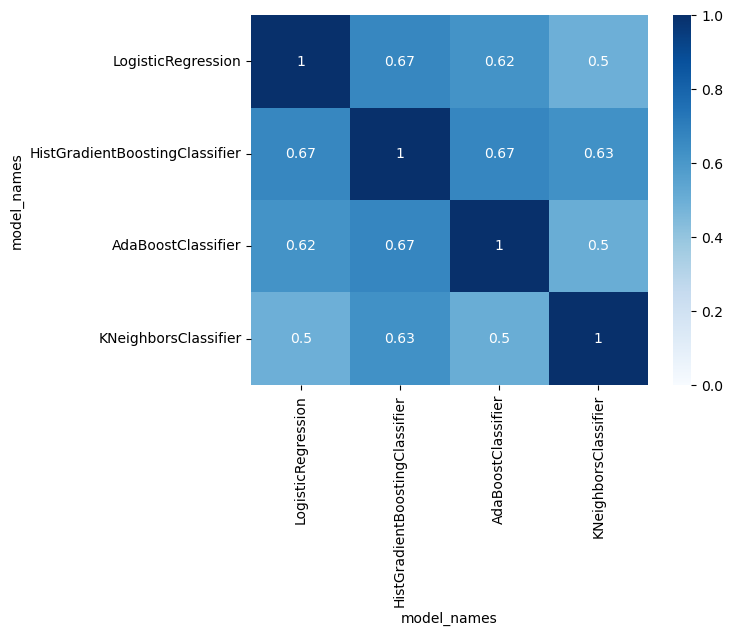

In [32]:
# check correlation between our model predictions

predictions = []
for model in results.display()['model']:
    predictions.append(model.predict(X_train))

sns.heatmap(
    data = pd.DataFrame(
    np.column_stack(tuple(predictions)),
    columns = results.display()['model_names']
    ).corr(),
    annot = True,
    cmap = 'Blues',
    vmin = 0,
    vmax = 1
);

In [33]:
# check coefficents from LogisticRegression
# feature_names = lr_best[0].get_feature_names_out()
# pca_component_values = lr_best[2].components_
# pca_components = pd.DataFrame(pca_component_values, columns=feature_names)
# pca_components['sum'] = pca_components.sum(axis=1)

# extract LogisticRegression coefficients
# lr_coefficients = lr_best[-1].coef_[0]
# pca_components['lr_coefficients'] = pd.Series(lr_coefficients)
# pca_components.iloc[:, -2:].sort_values(by='lr_coefficients', ascending=False)
# pca_table['lr_coefficients'] = pd.Series(lr_coefficients)
# features_coefs.rename(columns={0: 'feature', 1: 'coef'}, inplace=True)
# features_coefs.sort_values(by='coef', ascending=False).iloc[:50]

In [34]:
# pca_components

In [35]:
# create VotingClassifier ensemble with best performing classifiers
voting_clf = VotingClassifier([
    # ('HistGradientBoost', hgbc_best[-1]),
    ('AdaBoost', ada_best[-1]),
    ('LogReg', lr_best[-1]),
    # ('Kneighbors', knn_best[-1])
], voting='soft')

voting_params = {
    'sample__sampling_strategy': ['auto', 0.1, 0.25, 0.5],
#     'clf__GradientBoost__learning_rate': [0.01, 0.1],
#     'clf__GradientBoost__subsample': [0.7, 1.0],
#     'clf__GradientBoost__max_depth': [3, 7],
#     'clf__AdaBoost__learning_rate': [1.0, 2.0, 10],
#     'clf__LogReg__solver': ['liblinear'],
#     'clf__LogReg__C': [100, 10, 1.0],
}

In [36]:
voting_best = results.run_pipe(voting_clf, voting_params)

Fitting VotingClassifier
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Elapsed time: 0 minutes, 52 seconds
Best Score:  0.8352621033089825
Best Params:  {'pca__n_components': 93, 'sample__sampling_strategy': 0.5}



In [37]:
results.display()

,model_names,model,mean_train_roc_auc,mean_test_roc_auc,roc_auc_delta,best_params,runtime
4,VotingClassifier,"(ColumnTransformer(remainder='passthrough', sp...",0.8649,0.8033,0.0617,"{'pca__n_components': 93, 'sample__sampling_st...",52.81
0,LogisticRegression,"(ColumnTransformer(remainder='passthrough', sp...",0.8623,0.8009,0.0614,"{'clf__C': 0.1, 'clf__class_weight': 'balanced...",225.94
3,HistGradientBoostingClassifier,"(ColumnTransformer(remainder='passthrough', sp...",0.9085,0.7998,0.1087,"{'clf__l2_regularization': 1, 'clf__learning_r...",233.61
2,AdaBoostClassifier,"(ColumnTransformer(remainder='passthrough', sp...",0.8684,0.7970,0.0713,"{'clf__learning_rate': 1.0, 'clf__n_estimators...",190.24
1,KNeighborsClassifier,"(ColumnTransformer(remainder='passthrough', sp...",0.9533,0.7706,0.1827,"{'clf__n_neighbors': 15, 'clf__p': 2, 'clf__we...",84.89


Selecting the top performing model based on `balanced accuracy` score.

In [38]:
best_model = voting_best

## Model Performance

---

Random text

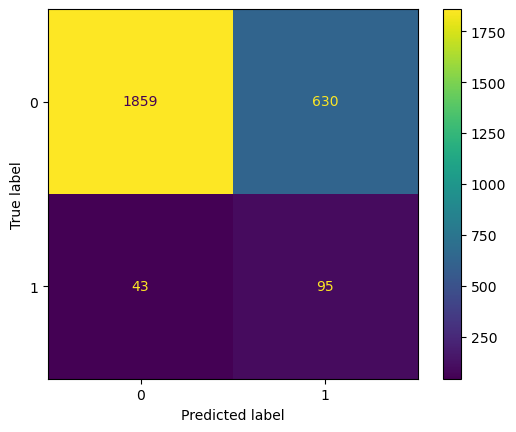

In [39]:
preds = best_model.predict(X_test)
cm_disp = ConfusionMatrixDisplay.from_predictions(y_test, preds)

In [40]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.98      0.75      0.85      2489
           1       0.13      0.69      0.22       138

    accuracy                           0.74      2627
   macro avg       0.55      0.72      0.53      2627
weighted avg       0.93      0.74      0.81      2627



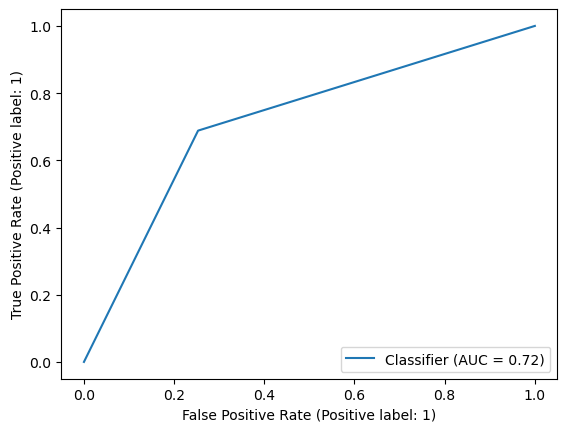

In [41]:
RocCurveDisplay.from_predictions(y_test, preds);

In [42]:
threshold = []
roc_auc_score_ = []

for p in np.linspace(0,1,101):
  threshold.append(p)
  y_pred = (best_model.predict_proba(X_train)[:,1] >= p).astype(int)
  roc_auc_score_.append(roc_auc_score(y_train, y_pred))

threshold_max = threshold[np.argmax(roc_auc_score_)]

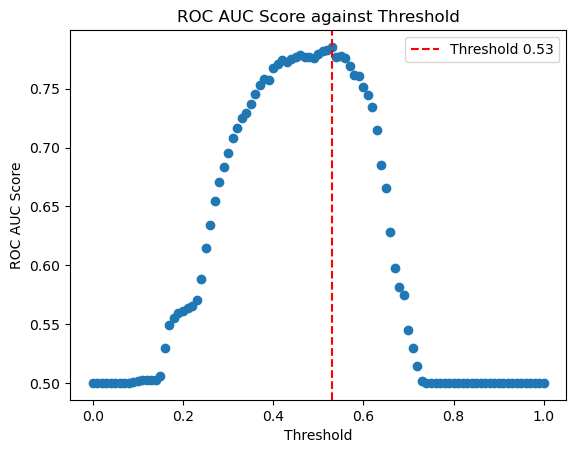

In [43]:
plt.scatter(threshold,roc_auc_score_)
plt.axvline(x=threshold_max, linestyle='--', c='red', label=f'Threshold {threshold_max}')
plt.xlabel("Threshold")
plt.ylabel("ROC AUC Score")
plt.title("ROC AUC Score against Threshold")
plt.legend(loc='best')
plt.show();

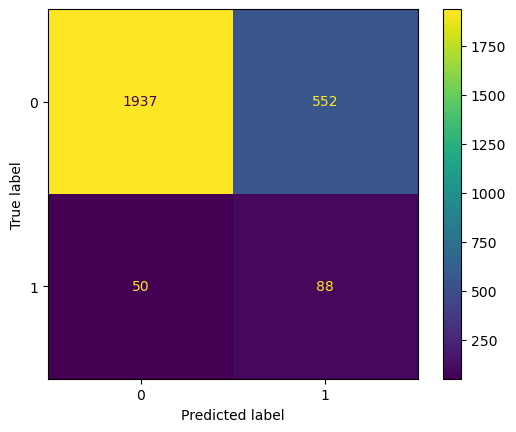

In [44]:
y_hat = pd.Series(np.where(best_model.predict_proba(X_test)[:,1] >= threshold_max, 1, 0), 
                     dtype='category')
cm_disp_yhat = ConfusionMatrixDisplay.from_predictions(y_test, y_hat)

In [45]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.97      0.78      0.87      2489
           1       0.14      0.64      0.23       138

    accuracy                           0.77      2627
   macro avg       0.56      0.71      0.55      2627
weighted avg       0.93      0.77      0.83      2627



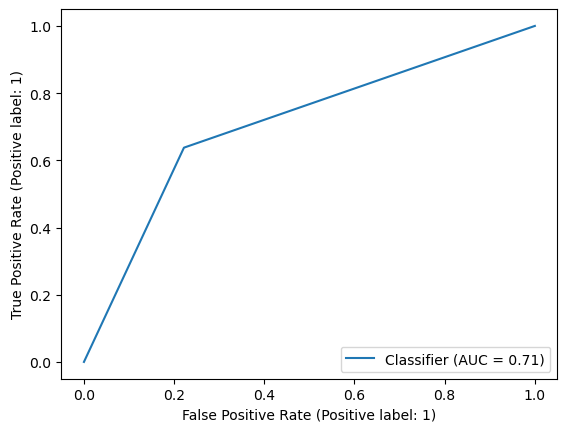

In [46]:
RocCurveDisplay.from_predictions(y_test, y_hat);

In [47]:
best_model.fit(X, y)

Pipeline(steps=[('col_transform',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('OneHotEncoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='infrequent_if_exist'),
                                                  ['Trap', 'Month', 'Week',
                                                   'Species']),
                                                 ('CountVectorizer',
                                                  Pipeline(steps=[('squeeze',
                                                                   FunctionTransformer(func=<function <lambda> at 0x000001BEA616FA60>)),
                                                                  ('vector'...
                                                  ['CodeSum'])])),
                ('scale', MinMaxScaler()), ('pca', PCA(n_components=93)),
                ('sample',
                 SMOTETomek(n_jobs=2, random_state=42, sampling_strategy=0.5)),
                ('clf',
                 VotingClassifier(estimators=[('AdaBoost',
                                               AdaBoostClassifier(random_state=42)),
                                              ('LogReg',
                                               LogisticRegression(C=0.1,
                                                                  class_weight='balanced',
                                                                  max_iter=400,
                                                                  random_state=42,
                                                                  solver='liblinear'))],
                                  voting='soft'))])

## Predictions

---

Prediction with `test.csv`.

In [48]:
df_test = pd.read_csv('../assets/df_merge_test.csv', parse_dates=['Date', 'Sunrise_1', 'Sunset_1'])

In [49]:
df_test = create_dt_features(df_test)

In [50]:
df_test.columns

Index(['Date', 'Species', 'Trap', 'Latitude', 'Longitude', 'AddressAccuracy',
       'Station', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb',
       'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'SnowFall',
       'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir',
       'AvgSpeed', 'Sunrise_1', 'Sunset_1', 'daylight_duration', 'Humidity',
       'Year', 'Month', 'Week', 'DayOfWeek', 'Tavg_7_days', 'Depart_7_days',
       'DewPoint_7_days', 'WetBulb_7_days', 'Heat_7_days', 'Cool_7_days',
       'Sunrise_7_days', 'Sunset_7_days', 'SnowFall_7_days',
       'PrecipTotal_7_days', 'StnPressure_7_days', 'SeaLevel_7_days',
       'ResultSpeed_7_days', 'ResultDir_7_days', 'AvgSpeed_7_days',
       'Humidity_7_days', 'Tavg_14_days', 'Depart_14_days', 'DewPoint_14_days',
       'WetBulb_14_days', 'Heat_14_days', 'Cool_14_days', 'Sunrise_14_days',
       'Sunset_14_days', 'SnowFall_14_days', 'PrecipTotal_14_days',
       'StnPressure_14_days', 'SeaLevel_14_days', '

In [51]:
# submission_predictions = best_model.predict(df_test[features])

# submission_predictions = pd.Series(np.where(best_model.predict_proba(df_test[features])[:,1] >= threshold_max, 1, 0), 
#                      dtype='category')

submission_predictions = pd.Series(np.where(best_model.predict_proba(df_test.drop(columns=['Date', 'Sunrise_1', 'Sunset_1', 'daylight_duration']))[:,1] >= threshold_max, 1, 0), 
                     dtype='category')

In [52]:
def create_predictions(predictions, filename):
    if not os.path.isdir('../output'):
        os.mkdir('../output')
    
    if not os.path.isfile(f'../output/{filename}.csv'):
        results_df = pd.DataFrame(predictions)
        results_df.insert(0, column='id', value=range(1, len(predictions)+1))
        results_df.to_csv(f"../output/{filename}.csv", header=["Id", "WnvPresent"], index=False)
    else:
        raise NameError(f'{filename}.csv already exists!')

In [53]:
output_filename = 'predictions_38'

create_predictions(submission_predictions, output_filename)

NameError: predictions_38.csv already exists!

In [ ]:
# results.display().to_csv(f'../output/params_{output_filename}.csv', index=False)